In [268]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ta
import tsfresh
import scipy.stats as stats
import numpy as np
import hurst
import EntropyHub

In [269]:
# Read my stocks and indexes from csv files
amazon_df = pd.read_csv('./Weekly series/Amazon_weekly.csv')
cac_df = pd.read_csv('./Weekly series/Cac_weekly.csv')
ibm_df = pd.read_csv('./Weekly series/IBM_weekly.csv')
microsoft_df = pd.read_csv('./Weekly series/Microsoft_weekly.csv')
sp500_df = pd.read_csv('./Weekly series/Sp500_weekly.csv')
nasdaq_df = pd.read_csv('./Weekly series/Nasdaq_weekly.csv')

In [270]:
sp500_df.head(2)

,Date,Open,High,Low,Close,Volume
0,1994-03-06,466.07,469.16,457.49,464.74,1537910000
1,1994-03-13,464.74,468.07,462.46,466.44,1566770000


Dfs share all the same structure
### Check encoding

In [271]:
nasdaq_encoding = nasdaq_df.dtypes
sp500_encoding = sp500_df.dtypes
amazon_encoding = amazon_df.dtypes
cac_encoding = cac_df.dtypes
ibm_encoding = ibm_df.dtypes
microsoft_encoding = microsoft_df.dtypes

encodings_df = pd.concat([amazon_encoding, cac_encoding, ibm_encoding, microsoft_encoding, sp500_encoding, nasdaq_encoding], axis=1)
encodings_df.columns = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'SP500', 'Nasdaq']
print("Features encoding in our stocks and indexes:\n")
print(encodings_df)

Features encoding in our stocks and indexes:

         Amazon      CAC      IBM Microsoft    SP500   Nasdaq
Date     object   object   object    object   object   object
Open    float64  float64  float64   float64  float64  float64
High    float64  float64  float64   float64  float64  float64
Low     float64  float64  float64   float64  float64  float64
Close   float64  float64  float64   float64  float64  float64
Volume    int64  float64    int64     int64    int64    int64


Encode Date in the right way

In [272]:
dfs = [amazon_df, cac_df, ibm_df, microsoft_df, sp500_df, nasdaq_df]

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'])

In [273]:
sp500_df.head(2)

,Date,Open,High,Low,Close,Volume
0,1994-03-06,466.07,469.16,457.49,464.74,1537910000
1,1994-03-13,464.74,468.07,462.46,466.44,1566770000


### Check missing values

In [274]:
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'SP500', 'Nasdaq']

missing_values_df = pd.concat([amazon_df.isnull().sum(), cac_df.isnull().sum(), ibm_df.isnull().sum(), microsoft_df.isnull().sum(), sp500_df.isnull().sum(), nasdaq_df.isnull().sum()], axis=1)
missing_values_df.columns = names
print("Concatenated missing values: \n")
print(missing_values_df)


Concatenated missing values: 

        Amazon  CAC  IBM  Microsoft  SP500  Nasdaq
Date         0    0    0          0      0       0
Open         0    2    0          0      2       2
High         0    2    0          0      2       2
Low          0    2    0          0      2       2
Close        0    2    0          0      2       2
Volume       0    0    0          0      0       0


- Stocks does not have missing values 
- indexes share the same number of missing values on the same columns
### Spot records with missing values

In [275]:
i = 0
names_indexes = ['CAC', 'SP500', 'Nasdaq']
indexes = [cac_df, sp500_df, nasdaq_df]

for df in indexes:
    missing_values = df[df.isnull().any(axis=1)]
    print(f"Records with missing values in {names_indexes[i]}:")
    i += 1
    print(missing_values)
    print()

Records with missing values in CAC:
           Date  Open  High  Low  Close  Volume
1523 2023-05-14   NaN   NaN  NaN    NaN     0.0
1524 2023-05-21   NaN   NaN  NaN    NaN     0.0

Records with missing values in SP500:
           Date  Open  High  Low  Close  Volume
1523 2023-05-14   NaN   NaN  NaN    NaN       0
1524 2023-05-21   NaN   NaN  NaN    NaN       0

Records with missing values in Nasdaq:
           Date  Open  High  Low  Close  Volume
1523 2023-05-14   NaN   NaN  NaN    NaN       0
1524 2023-05-21   NaN   NaN  NaN    NaN       0



They all have the same behavior

In [276]:
for df, name in zip(indexes, names_indexes):
    records_range = df[(df['Date'] >= datetime.strptime('2023-04-30', '%Y-%m-%d')) & (df['Date'] <= datetime.strptime('2023-06-04', '%Y-%m-%d'))]
    records_range = records_range.sort_values('Date', ascending=False)
    print(f"Records in {name}_df within the range '2023-04-30' to '2023-06-04':")
    print(records_range,'\n')

Records in CAC_df within the range '2023-04-30' to '2023-06-04':
           Date     Open     High      Low    Close       Volume
1526 2023-06-04  7352.93  7356.57  7083.60  7270.69  446640000.0
1525 2023-05-28  7457.18  7459.37  7197.40  7319.18  260960000.0
1524 2023-05-21      NaN      NaN      NaN      NaN          0.0
1523 2023-05-14      NaN      NaN      NaN      NaN          0.0
1522 2023-05-07  7466.82  7505.92  7374.06  7403.83  144150000.0
1521 2023-04-30  7545.60  7581.26  7403.20  7491.50  394540000.0 

Records in SP500_df within the range '2023-04-30' to '2023-06-04':
           Date       Open       High        Low      Close       Volume
1526 2023-06-04  4226.7100  4290.6699  4166.1499  4282.3701  12275781000
1525 2023-05-28  4176.7998  4212.8701  4103.9800  4205.4502  10130943000
1524 2023-05-21        NaN        NaN        NaN        NaN            0
1523 2023-05-14        NaN        NaN        NaN        NaN            0
1522 2023-05-07  4166.7900  4186.9199  4089.72

### Imputation

Open price is usually equal or at least very similar to the Close price of the previous week. 
- Thus we can impute **close price of 2023-05-21** with open price of 2023-05-28 and **open price of 2023-05-14** with close price of 2023-05-07 with high confidence.
- **2023-05-14 Close and 2023-05-21 Open** will be reasonably imputated as the mean between 2023-05-14 Open and 2023-05-21 Close.

In [277]:
for df in indexes:
    df.loc[df['Date'] == '2023-05-21', 'Close'] = df.loc[df['Date'] == '2023-05-28', 'Open'].values[0]
    df.loc[df['Date'] == '2023-05-14', 'Open'] = df.loc[df['Date'] == '2023-05-07', 'Close'].values[0]
    df.loc[df['Date'] == '2023-05-14', 'Close'] = (df.loc[df['Date'] == '2023-05-14', 'Open'].values[0] + df.loc[df['Date'] == '2023-05-21', 'Close'].values[0]) / 2
    df.loc[df['Date'] == '2023-05-21', 'Open'] = (df.loc[df['Date'] == '2023-05-14', 'Open'].values[0] + df.loc[df['Date'] == '2023-05-21', 'Close'].values[0]) / 2

In [278]:
for df, name in zip(indexes, names_indexes):
    records_range = df[(df['Date'] >= datetime.strptime('2023-04-30', '%Y-%m-%d')) & (df['Date'] <= datetime.strptime('2023-06-04', '%Y-%m-%d'))]
    records_range = records_range.sort_values('Date', ascending=False)
    print(f"Records in {name}_df within the range '2023-04-30' to '2023-06-04':")
    print(records_range,'\n')

Records in CAC_df within the range '2023-04-30' to '2023-06-04':
           Date      Open     High      Low     Close       Volume
1526 2023-06-04  7352.930  7356.57  7083.60  7270.690  446640000.0
1525 2023-05-28  7457.180  7459.37  7197.40  7319.180  260960000.0
1524 2023-05-21  7430.505      NaN      NaN  7457.180          0.0
1523 2023-05-14  7403.830      NaN      NaN  7430.505          0.0
1522 2023-05-07  7466.820  7505.92  7374.06  7403.830  144150000.0
1521 2023-04-30  7545.600  7581.26  7403.20  7491.500  394540000.0 

Records in SP500_df within the range '2023-04-30' to '2023-06-04':
           Date       Open       High        Low      Close       Volume
1526 2023-06-04  4226.7100  4290.6699  4166.1499  4282.3701  12275781000
1525 2023-05-28  4176.7998  4212.8701  4103.9800  4205.4502  10130943000
1524 2023-05-21  4154.4348        NaN        NaN  4176.7998            0
1523 2023-05-14  4132.0698        NaN        NaN  4154.4348            0
1522 2023-05-07  4166.7900  4186

A reasonable way to impute Highest & Lowest price of the week values is:
- Put the **greater among the Open & Close price as High**
- Put the **lower among the Open & Close price as Low**

In [279]:
# Create a list of dates to check
dates = ['2023-05-14', '2023-05-21']

# Check the values of the 'Open' and 'Close' columns for the dates in the list
for df in indexes:
    for date in dates:
        df.loc[df['Date'] == date, ['High', 'Low']] = [max(df.loc[df['Date'] == date, ['Open', 'Close']].values[0]), 
                                                                   min(df.loc[df['Date'] == date, ['Open', 'Close']].values[0])]

How to impute volume?

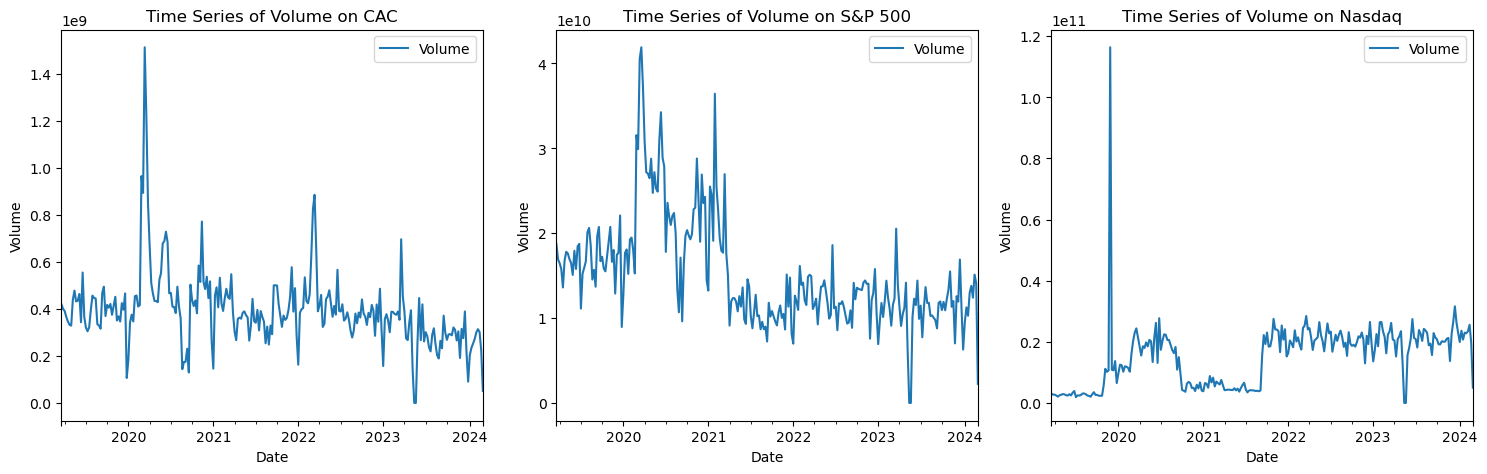

In [280]:
cac_last_5_years = cac_df[cac_df['Date'] >= datetime.now() - timedelta(days=365*5)]
sp500_last_5_years = sp500_df[sp500_df['Date'] >= datetime.now() - timedelta(days=365*5)]
nasdaq_last_5_years = nasdaq_df[nasdaq_df['Date'] >= datetime.now() - timedelta(days=365*5)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the Date and Volume columns for cac_df
cac_last_5_years.plot(x='Date', y='Volume', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Volume')
axs[0].set_title('Time Series of Volume on CAC')

# Plot the Date and Volume columns for sp500_df
sp500_last_5_years.plot(x='Date', y='Volume', ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volume')
axs[1].set_title('Time Series of Volume on S&P 500')

# Plot the Date and Volume columns for nasdaq_df
nasdaq_last_5_years.plot(x='Date', y='Volume', ax=axs[2])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Volume')
axs[2].set_title('Time Series of Volume on Nasdaq')

plt.tight_layout()
plt.show()


Looking at the distribution of volume over the last 5 years a good imputation is the **mean of the volume had during that year**.

In [281]:
# Dates where to impute
dates = ['2023-05-14', '2023-05-21']

# Impute as the mean of the volume in 2023
for df in indexes:
    df.loc[(df['Date'] == dates[0]) | (df['Date'] == dates[1]), ['Volume']] = df.loc[df['Date'].dt.year == 2023, 'Volume'].mean()


In [282]:
for df, name in zip(indexes, names_indexes):
    records_range = df[(df['Date'] >= datetime.strptime('2023-04-30', '%Y-%m-%d')) & (df['Date'] <= datetime.strptime('2023-06-04', '%Y-%m-%d'))]
    records_range = records_range.sort_values('Date', ascending=False)
    print(f"Records in {name} within the range '2023-04-30' to '2023-06-04':")
    print(records_range,'\n')

Records in CAC within the range '2023-04-30' to '2023-06-04':
           Date      Open      High       Low     Close        Volume
1526 2023-06-04  7352.930  7356.570  7083.600  7270.690  4.466400e+08
1525 2023-05-28  7457.180  7459.370  7197.400  7319.180  2.609600e+08
1524 2023-05-21  7430.505  7457.180  7430.505  7457.180  2.966588e+08
1523 2023-05-14  7403.830  7430.505  7403.830  7430.505  2.966588e+08
1522 2023-05-07  7466.820  7505.920  7374.060  7403.830  1.441500e+08
1521 2023-04-30  7545.600  7581.260  7403.200  7491.500  3.945400e+08 

Records in SP500 within the range '2023-04-30' to '2023-06-04':
           Date       Open       High        Low      Close        Volume
1526 2023-06-04  4226.7100  4290.6699  4166.1499  4282.3701  1.227578e+10
1525 2023-05-28  4176.7998  4212.8701  4103.9800  4205.4502  1.013094e+10
1524 2023-05-21  4154.4348  4176.7998  4154.4348  4176.7998  1.096365e+10
1523 2023-05-14  4132.0698  4154.4348  4132.0698  4154.4348  1.096365e+10
1522 2023-05

# ??? Which window to choose ???

In [283]:
def approx_entropy(ts, m=2, r=None):
    if r is None:
        r = 0.2 * np.std(ts)
    n = len(ts)
    def _phi(m):
        x = np.array([ts[i : i + m] for i in range(n - m + 1)])
        C = np.sum([np.sum(np.abs(x[i] - x) <= r, axis=1) / (n - m + 1) for i in range(n - m + 1)]) / (n - m + 1)
        return np.log(C)
    return _phi(m) - _phi(m + 1)

# Compute technical indicators and time series functions for each dataframe using the ta library
for df in dfs:
    # Technical indicators
    df['sma'] = ta.trend.sma_indicator(df['Close'], window=14) #Simple Moving Averages (SMA)
    df['ema'] = ta.trend.ema_indicator(df['Close'], window=14) # Exponential Moving Averages (EMA)
    df['stoch_osc'] = ta.momentum.stoch(df['High'], df['Low'], df['Close']) # Stochastic Oscillator
    df['rsi'] = ta.momentum.rsi(df['Close']) # Relative Strength Index (RSI)
    df['macd'] = ta.trend.macd(df['Close']) # Moving Average Convergence Divergence (MACD)

    # Time series functions
    df['skewness'] = df['Close'].rolling(window=14).apply(lambda x: stats.skew(x, bias=False)) # Skewness
    df['kurtosis'] = df['Close'].rolling(window=14).apply(lambda x: stats.kurtosis(x, bias=False)) # Kurtosis
    H, _, _  = hurst.compute_Hc(df['Close'], kind='price') # Hurst exponent
    df['hurst'] = H 
    df['approx_entropy'] = df['Close'].rolling(window=50).apply(lambda x: approx_entropy(x) if len(x.dropna()) > 20 else np.nan) # Approximate Entropy

- SMA and EMA (14 Weeks): Targets medium-term trends, reflecting quarterly performance which is crucial for understanding market dynamics over significant financial periods.
- Stochastic Oscillator (Default: 14): Spot overbought or oversold conditions, important for predicting potential price reversals on a medium-term basis.
- RSI (14 Weeks): Chosen to evaluate medium-term market momentum, useful in identifying overbought or oversold conditions over a quarter.
- MACD (14 weeks): Utilized to detect changes in medium-term trend strength and direction, offering signals for potential trading opportunities.
- Skewness and Kurtosis (Default: 14): Analyzes the return distribution's asymmetry and tail risks within a quarterly frame, providing insights into market volatility and risk.
- Hurst Exponent: Assesses the entire series to gauge long-term dependency or memory, helping to categorize market behavior as trending, random, or mean-reverting.
- Approximate Entropy (50 Weeks): Measures complexity and predictability over an annual scale highlighting annual patterns in market efficiency.

The ta library provides technical analysis indicators for financial data: https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html 

The hurst library is used for calculating the Hurst exponent, which is a measure of long-term memory in time series data. We used kind = 'price', which simulates how prices evolve in financial markets through compounding returns. https://pypi.org/project/hurst/

In [284]:
sp500_df.head(30)

,Date,Open,High,Low,Close,Volume,sma,ema,stoch_osc,rsi,macd,skewness,kurtosis,hurst,approx_entropy
0,1994-03-06,466.07,469.16,457.49,464.74,1.537910e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
1,1994-03-13,464.74,468.07,462.46,466.44,1.566770e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
2,1994-03-20,466.44,471.09,465.48,471.06,1.637710e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
3,1994-03-27,471.06,471.06,460.58,460.58,1.364500e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
4,1994-04-03,460.58,461.12,436.16,445.77,1.386810e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
5,1994-04-10,445.66,451.10,435.86,447.10,1.565750e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
6,1994-04-17,447.12,450.80,442.62,446.18,1.363880e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
7,1994-04-24,446.27,449.96,438.83,447.63,1.635770e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
8,1994-05-01,447.64,452.79,447.58,450.91,1.169610e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN
9,1994-05-08,450.91,453.98,445.64,447.82,1.399940e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839757,NaN


In [285]:
sp500_df[45:65]

,Date,Open,High,Low,Close,Volume,sma,ema,stoch_osc,rsi,macd,skewness,kurtosis,hurst,approx_entropy
45,1995-01-15,460.67,466.43,458.65,465.97,1.627330e+09,460.782857,460.178201,72.473321,54.776261,0.024205,-0.194687,0.512118,0.839757,NaN
46,1995-01-22,465.97,470.43,463.99,464.78,1.667400e+09,460.474286,460.791774,68.738230,53.729541,0.390530,-0.221959,1.025100,0.839757,NaN
47,1995-01-29,464.78,471.36,461.14,470.39,1.628110e+09,460.867143,462.071538,86.346516,57.821487,1.120607,-0.146422,0.412184,0.839757,NaN
48,1995-02-05,470.39,479.91,467.49,478.65,1.888560e+09,461.215714,464.281999,96.597353,63.008631,2.338752,0.402631,1.275142,0.839757,NaN
49,1995-02-12,478.64,482.60,478.36,481.46,1.579920e+09,462.585714,466.572399,97.129909,64.603441,3.490646,0.588347,0.360475,0.839757,-0.429004
50,1995-02-19,481.46,485.54,480.89,481.97,1.643990e+09,463.987143,468.625413,91.631505,64.899225,4.394031,0.460387,-0.563444,0.839757,-0.431535
51,1995-02-26,481.95,489.19,481.94,488.11,1.344760e+09,465.890000,471.223358,97.667890,68.330367,5.541538,0.400516,-0.902386,0.839757,-0.414189
52,1995-03-05,488.26,488.26,483.07,485.42,1.626480e+09,468.256429,473.116243,91.859210,65.317897,6.162844,0.135730,-1.180743,0.839757,-0.414752
53,1995-03-12,485.42,490.37,479.70,489.57,1.706460e+09,470.847143,475.310078,98.315435,67.684881,6.910444,-0.069270,-1.165501,0.839757,-0.424794
54,1995-03-19,489.57,496.67,489.35,495.52,1.685030e+09,474.315714,478.004734,97.747307,70.765507,7.892062,0.156663,-1.563549,0.839757,-0.424930


- Since on the first 25 rows we miss lot of indicator and functions we just **delete these rows**.
- Since approximate entropy does not change that much weekly we can just impute remaining missing values in the column (25) with the **first available value** in the respective time series

In [286]:
# Function to apply changes to the DataFrames
def modify_df(df):
    modified_df = df.assign(approx_entropy=df['approx_entropy'].fillna(df.loc[49, 'approx_entropy'])).iloc[25:]
    return modified_df

# Explicitly modify each DataFrame
amazon_df = modify_df(amazon_df)
cac_df = modify_df(cac_df)
ibm_df = modify_df(ibm_df)
microsoft_df = modify_df(microsoft_df)
sp500_df = modify_df(sp500_df)
nasdaq_df = modify_df(nasdaq_df)